In [3]:
import os

import joblib
import kagglehub
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

In [4]:
DATA_PATH = "diamonds.csv"
TARGET_COL = "price"
MODEL_PATH = "diamond_pricing_model.joblib"
TEST_SIZE = 0.2
RANDOM_STATE = 42
MIN_COUNT = 100

In [5]:
def load_data(path: str) -> pd.DataFrame:
  if not os.path.exists(path):
    raise FileNotFoundError()
  df = pd.read_csv(path)
  print(f'Loaded initial dataset with shape {df.shape}')
  return df

In [6]:
df_raw = load_data(DATA_PATH)
df_raw.info()
df_raw.describe().T

Loaded initial dataset with shape (53940, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   x        53940 non-null  float64
 7   y        53940 non-null  float64
 8   z        53940 non-null  float64
 9   price    53940 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


,count,mean,std,min,25%,50%,75%,max
carat,53940.0,0.797940,0.474011,0.2,0.40,0.70,1.04,5.01
depth,53940.0,61.749405,1.432621,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.457184,2.234491,43.0,56.00,57.00,59.00,95.00
x,53940.0,5.731157,1.121761,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.734526,1.142135,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.538734,0.705699,0.0,2.91,3.53,4.04,31.80
price,53940.0,3932.799722,3989.439738,326.0,950.00,2401.00,5324.25,18823.00


In [7]:
duplicates = df_raw[df_raw.duplicated()]
print(f' Number of duplicates: {len(duplicates)}')
duplicates.info()
duplicate_indices = df_raw.index[df_raw.duplicated()].tolist()
check = (duplicate_indices == duplicates.index.tolist())
print(check)

 Number of duplicates: 146
<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, 1005 to 52861
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    146 non-null    float64
 1   cut      146 non-null    object 
 2   color    146 non-null    object 
 3   clarity  146 non-null    object 
 4   depth    146 non-null    float64
 5   table    146 non-null    float64
 6   x        146 non-null    float64
 7   y        146 non-null    float64
 8   z        146 non-null    float64
 9   price    146 non-null    int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 12.5+ KB
True


In [8]:
df_nodups = df_raw.drop_duplicates(keep="first").reset_index(drop=True)
df_nodups_noprice_numeric = df_nodups.drop(TARGET_COL, axis=1).select_dtypes(include=np.number)

print("Shape before removing duplicates:", df_raw.shape)
print("Shape after removing duplicates:", df_nodups.shape)
unique_counts_df = df_nodups.nunique()
print(unique_counts_df)
total_val_counts = df_nodups.nunique().sum()
print(f'Total unique counts: {total_val_counts}')

Shape before removing duplicates: (53940, 10)
Shape after removing duplicates: (53794, 10)
carat        273
cut            5
color          7
clarity        8
depth        184
table        127
x            554
y            552
z            375
price      11602
dtype: int64
Total unique counts: 13687


In [9]:
vc_dfs = []

for col in df_nodups_noprice_numeric.columns:
    # get val counts for current col
    vc = df_nodups[col].value_counts()

    # add value counts to two-col DF of the form [value, count]
    vc = vc.reset_index()
    vc.columns = [f'{col}_value', f'{col}_count']

    vc_dfs.append(vc)

# concatenate all two-col frames into value_count table
vc_table = pd.concat(vc_dfs, axis=1).fillna("")
print(vc_table)

    carat_value carat_count depth_value depth_count table_value table_count  \
0           0.3      2596.0        62.0      2233.0        56.0      9851.0   
1          1.01      2240.0        61.9      2160.0        57.0      9695.0   
2          0.31      2238.0        61.8      2069.0        58.0      8352.0   
3           0.7      1981.0        62.2      2033.0        59.0      6562.0   
4          0.32      1827.0        62.1      2011.0        55.0      6242.0   
..          ...         ...         ...         ...         ...         ...   
549                                                                           
550                                                                           
551                                                                           
552                                                                           
553                                                                           

     x_value  x_count y_value y_count z_value z_cou

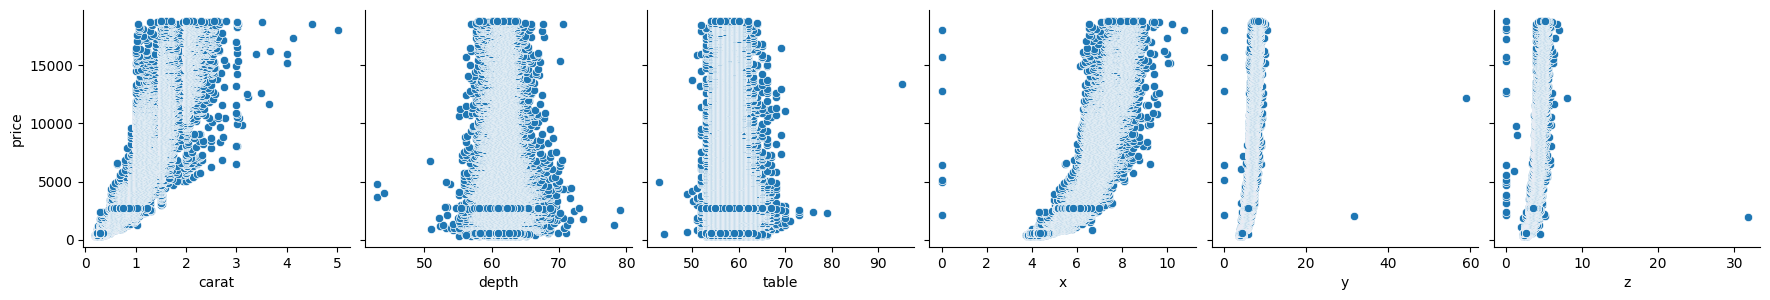

In [10]:
sns.pairplot(
    data=df_nodups,
    x_vars=df_nodups_noprice_numeric.columns.tolist(),
    y_vars=[TARGET_COL],
    height=3
)

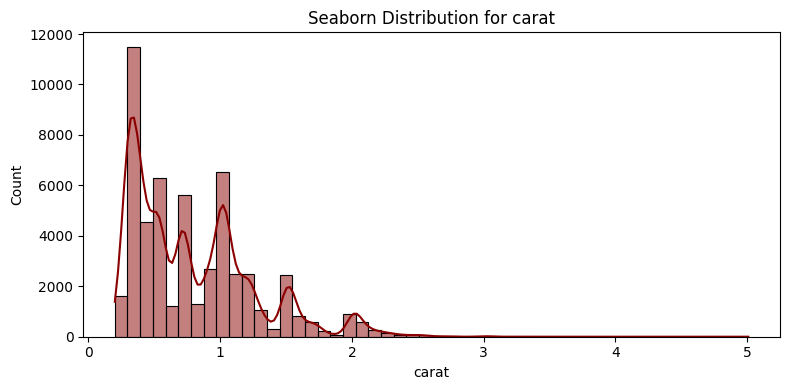

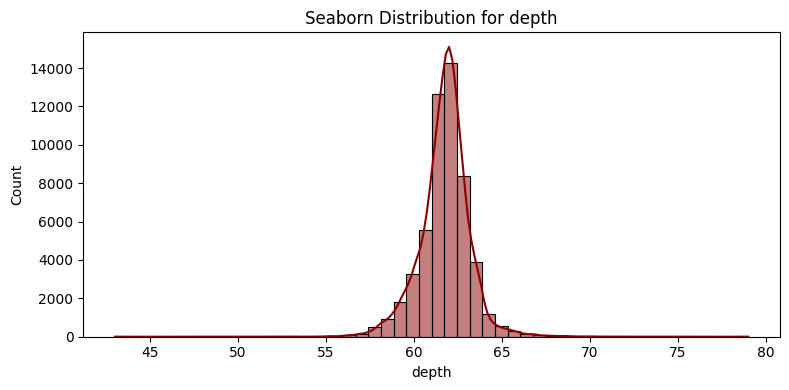

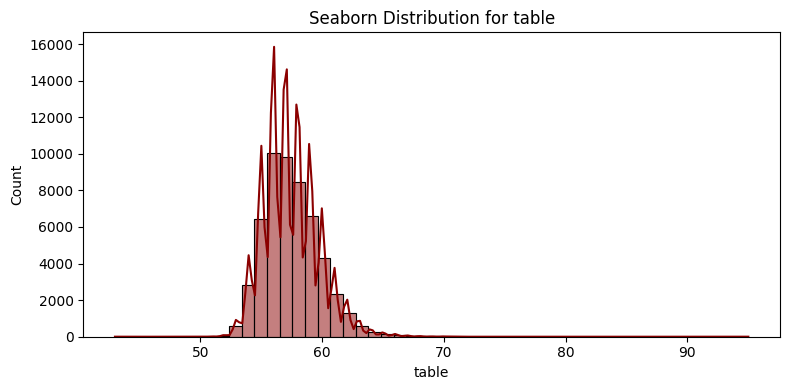

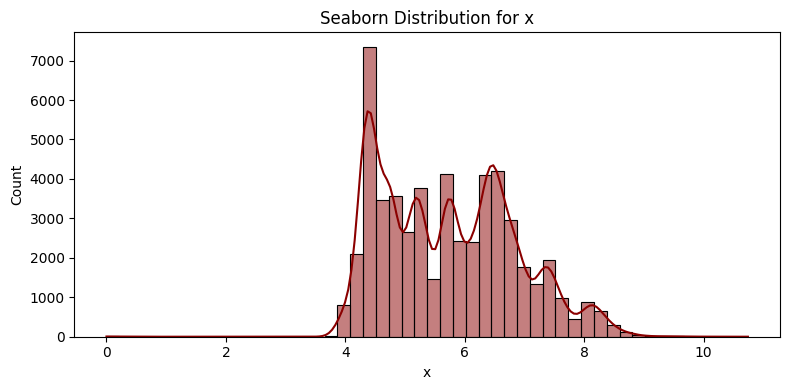

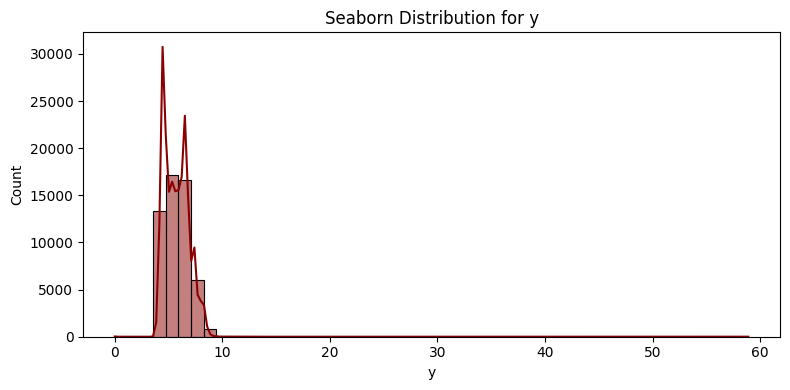

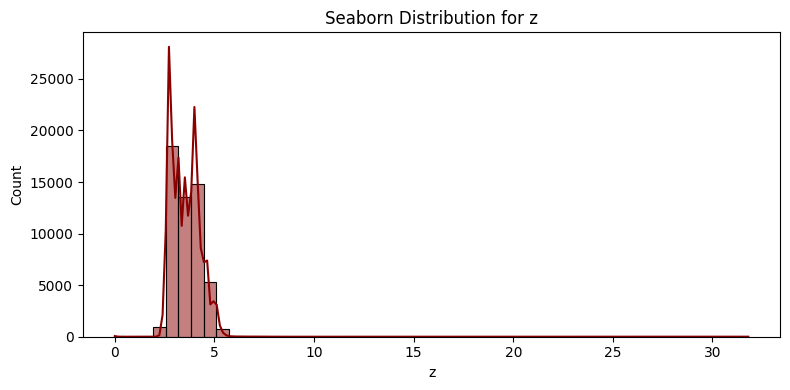

In [11]:
for col in df_nodups_noprice_numeric.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_raw[col], kde=True, bins=50, color='darkred')
    plt.title(f"Seaborn Distribution for {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [12]:
for col in df_nodups.drop(['price'], axis=1).select_dtypes(['float64', 'int64']).columns:
    print(f'Skewness for {col}: {df_nodups[col].skew()}')

Skewness for carat: 1.1136511411526497
Skewness for depth: -0.11425026120643586
Skewness for table: 0.7922272870802959
Skewness for x: 0.37962390611337177
Skewness for y: 2.4457680214087554
Skewness for z: 1.5290234285039366


In [13]:
for col in ['carat', 'table']:
    print(f'Log-transformed skewness for {col}: {np.log(df_nodups[col]).skew()}')

Log-transformed skewness for carat: 0.09439629775733568
Log-transformed skewness for table: 0.5956370357465796


In [14]:
for col in ['carat', 'table', 'depth']:
    clean = df_nodups[col]
    box, lam = stats.boxcox(clean)
    print(col, "skew:", pd.Series(box).skew(), "lambda:", lam)

carat skew: 0.020064874386431293 lambda: -0.09324682311924386
table skew: 0.0 lambda: -4.118629906607164
depth skew: 0.07074036555772921 lambda: 1.721837306748676


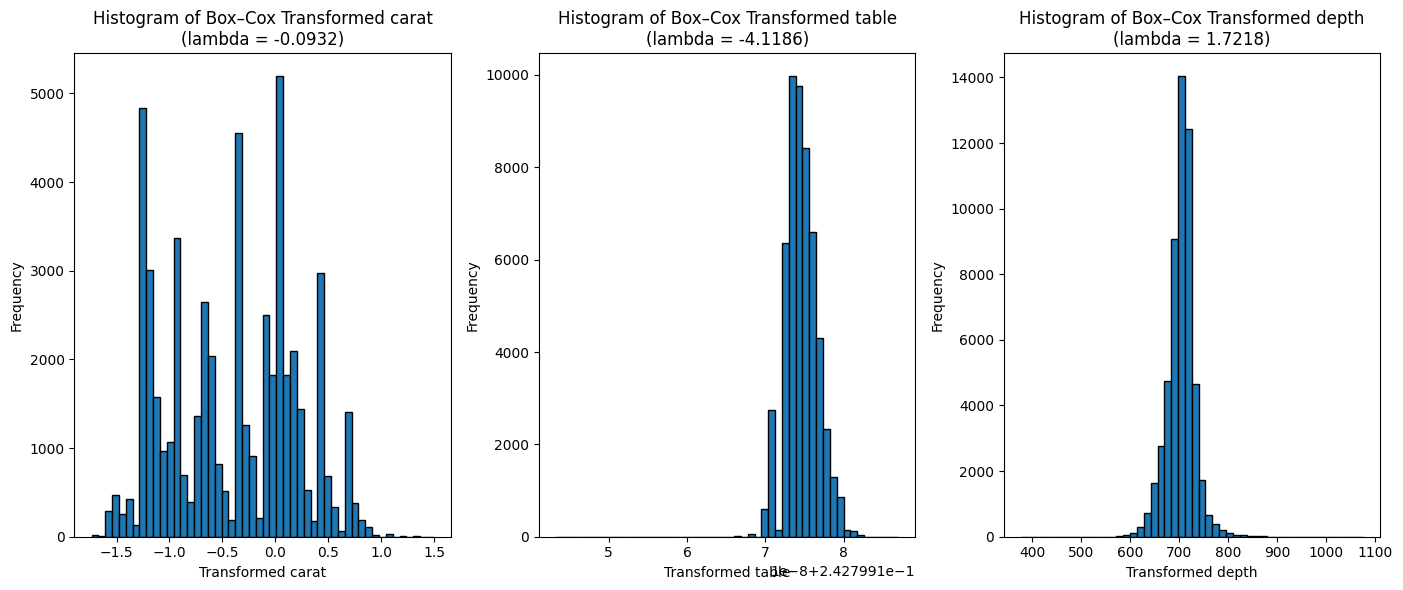

In [15]:
plt.figure(figsize=(14, 6))

for i, col in enumerate(['carat', 'table', 'depth']):
    # Extract and clean data
    clean = df_nodups[col][df_nodups[col] > 0]

    # Apply Box–Cox
    transformed, lam = stats.boxcox(clean)

    # Plot histogram
    plt.subplot(1, 3, i+1)
    plt.hist(transformed, bins=50, edgecolor='black')
    plt.title(f"Histogram of Box–Cox Transformed {col}\n(lambda = {lam:.4f})")
    plt.xlabel(f"Transformed {col}")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

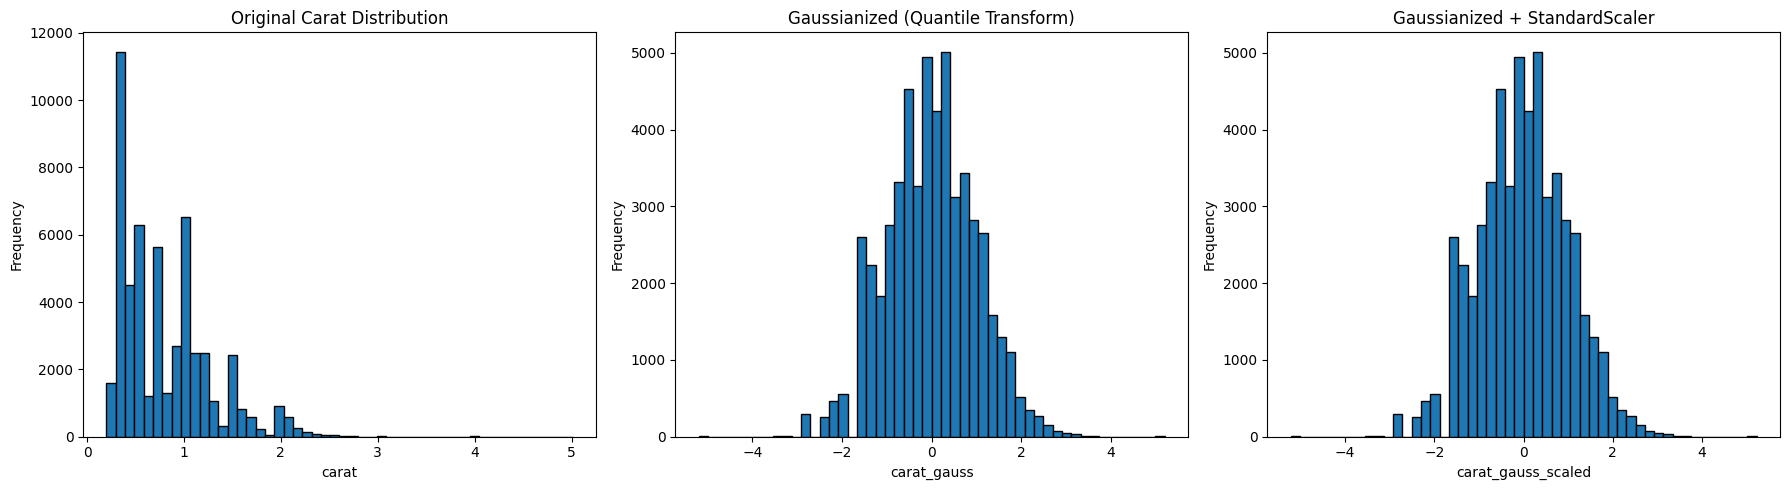

In [16]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer, StandardScaler

# Transform
qt = QuantileTransformer(output_distribution="normal", random_state=0)
df_nodups['carat_gauss'] = qt.fit_transform(df_nodups[['carat']])

scaler = StandardScaler()
df_nodups['carat_gauss_scaled'] = scaler.fit_transform(df_nodups[['carat_gauss']])

# Plotting
plt.figure(figsize=(18, 5))

# 1. Original distribution
plt.subplot(1, 3, 1)
plt.hist(df_nodups['carat'], bins=50, edgecolor='black')
plt.title("Original Carat Distribution")
plt.xlabel("carat")
plt.ylabel("Frequency")

# 2. Quantile → Normal distribution
plt.subplot(1, 3, 2)
plt.hist(df_nodups['carat_gauss'], bins=50, edgecolor='black')
plt.title("Gaussianized (Quantile Transform)")
plt.xlabel("carat_gauss")
plt.ylabel("Frequency")

# 3. Gaussianized + Standard Scaled
plt.subplot(1, 3, 3)
plt.hist(df_nodups['carat_gauss_scaled'], bins=50, edgecolor='black')
plt.title("Gaussianized + StandardScaler")
plt.xlabel("carat_gauss_scaled")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [17]:
print(f'Skewness for carat_gauss: {df_nodups["carat_gauss"].skew()}')
print(f'Skewness for carat_gauss_scaled: {df_nodups["carat_gauss_scaled"].skew()}')
check2 = (df_nodups["carat_gauss"].skew() < df_nodups["carat_gauss_scaled"].skew())
print(check2)

Skewness for carat_gauss: 0.00027313820513121987
Skewness for carat_gauss_scaled: 0.0002731382051313446
True


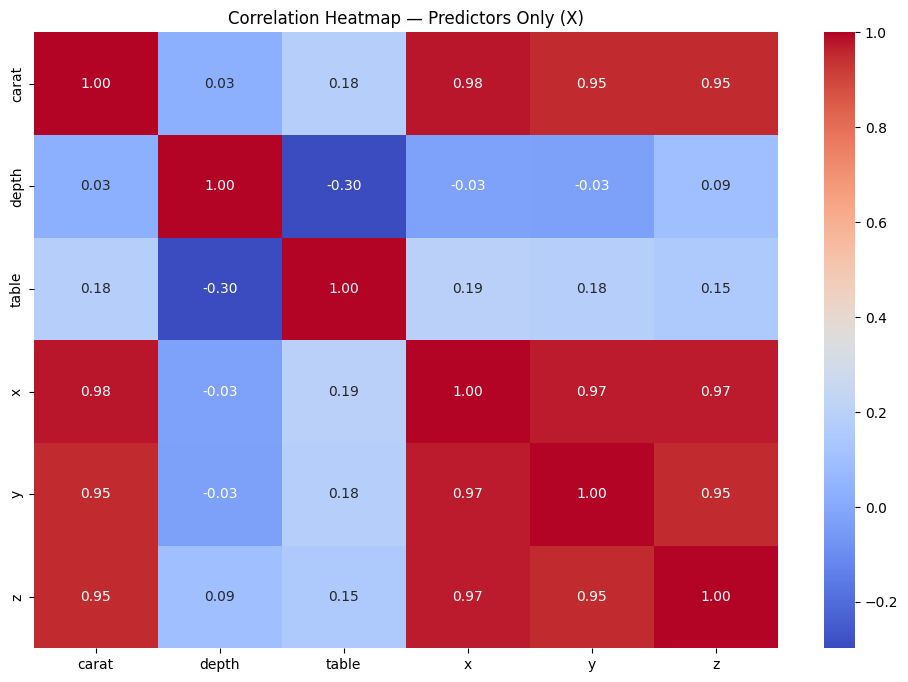

In [20]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_nodups_noprice_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap — Predictors Only (X)")
plt.show()

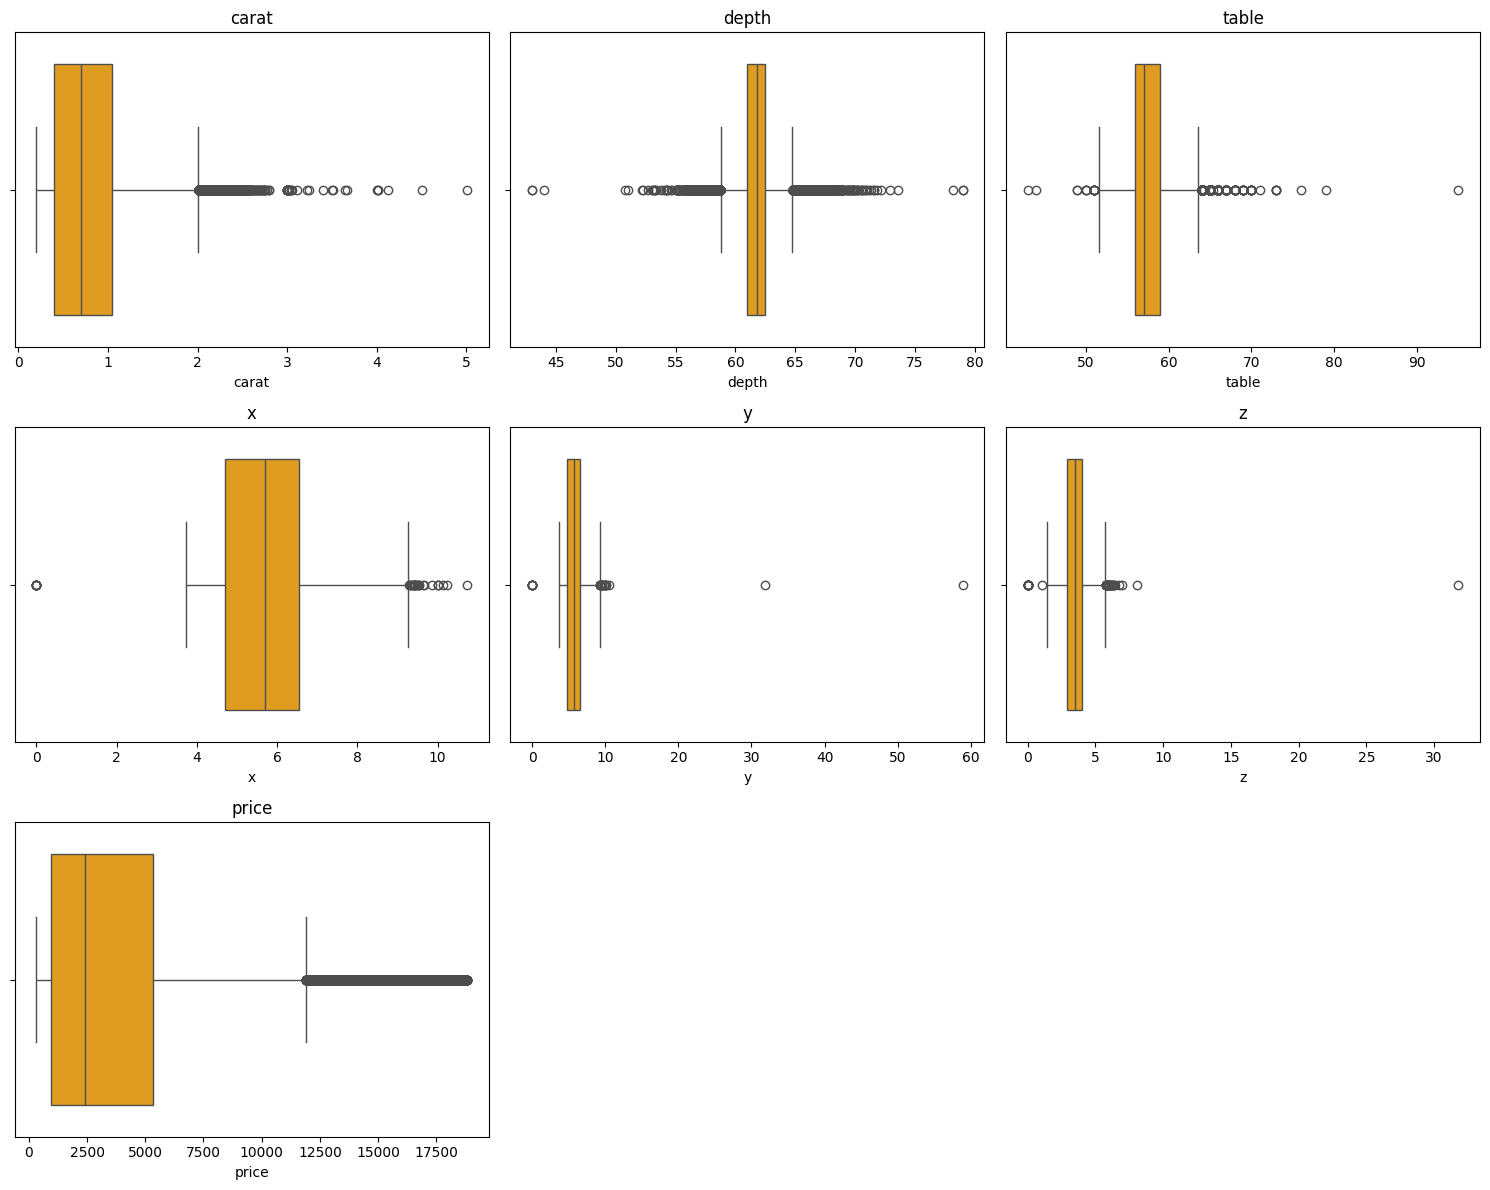

In [24]:
numeric_cols = df_raw.select_dtypes(include=np.number).columns
n = len(numeric_cols)

plt.figure(figsize=(15, 4 * ((n + 2) // 3)))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot((n + 2) // 3, 3, i)
    sns.boxplot(x=df_raw[col], color='orange')
    plt.title(col)

plt.tight_layout()
plt.show()

In [25]:
X = df_raw.drop(TARGET_COL, axis=1)
y = df_raw[TARGET_COL]